<center><img src="images/clothing.jpg"></center>

Your mission is to use text embeddings and Python to analyze these reviews, uncover underlying themes, and understand customer sentiments. This analysis will help improve customer service and product offerings.

## The Data

You will be working with a dataset specifically focusing on customer reviews. Below is the data dictionary for the relevant field:

## womens_clothing_e-commerce_reviews.csv

| Column        | Description                           |
|---------------|---------------------------------------|
| `'Review Text'` | Textual feedback provided by customers about their shopping experience and product quality. |

Armed with access to powerful embedding API services, you will process the reviews, extract meaningful insights, and present your findings.



In [31]:
import os
import openai
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import chromadb
from scipy.spatial import distance
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

reviews = pd.read_csv("womens_clothing_e-commerce_reviews.csv")
print(reviews.head())
review_texts = reviews['Review Text'].dropna()

   Review ID  Clothing ID  Age  ...   Division Name Department Name  Class Name
0          0          767   33  ...       Initmates        Intimate   Intimates
1          1         1080   34  ...         General         Dresses     Dresses
2          2         1077   60  ...         General         Dresses     Dresses
3          3         1049   50  ...  General Petite         Bottoms       Pants
4          4          847   47  ...         General            Tops     Blouses

[5 rows x 11 columns]


In [32]:
client = openai.OpenAI()
responses = client.embeddings.create(
    model = "text-embedding-3-small",
    input = review_texts.tolist()
)
response_dict = responses.model_dump()

embeddings = [response["embedding"] for response in response_dict["data"]]

In [33]:
def apply_TSNE(embeddings):
    tsne = TSNE(
        n_components = 2,
        perplexity = 5
    )
    return tsne.fit_transform(embeddings)

embeddings_2d = apply_TSNE(np.array(embeddings))

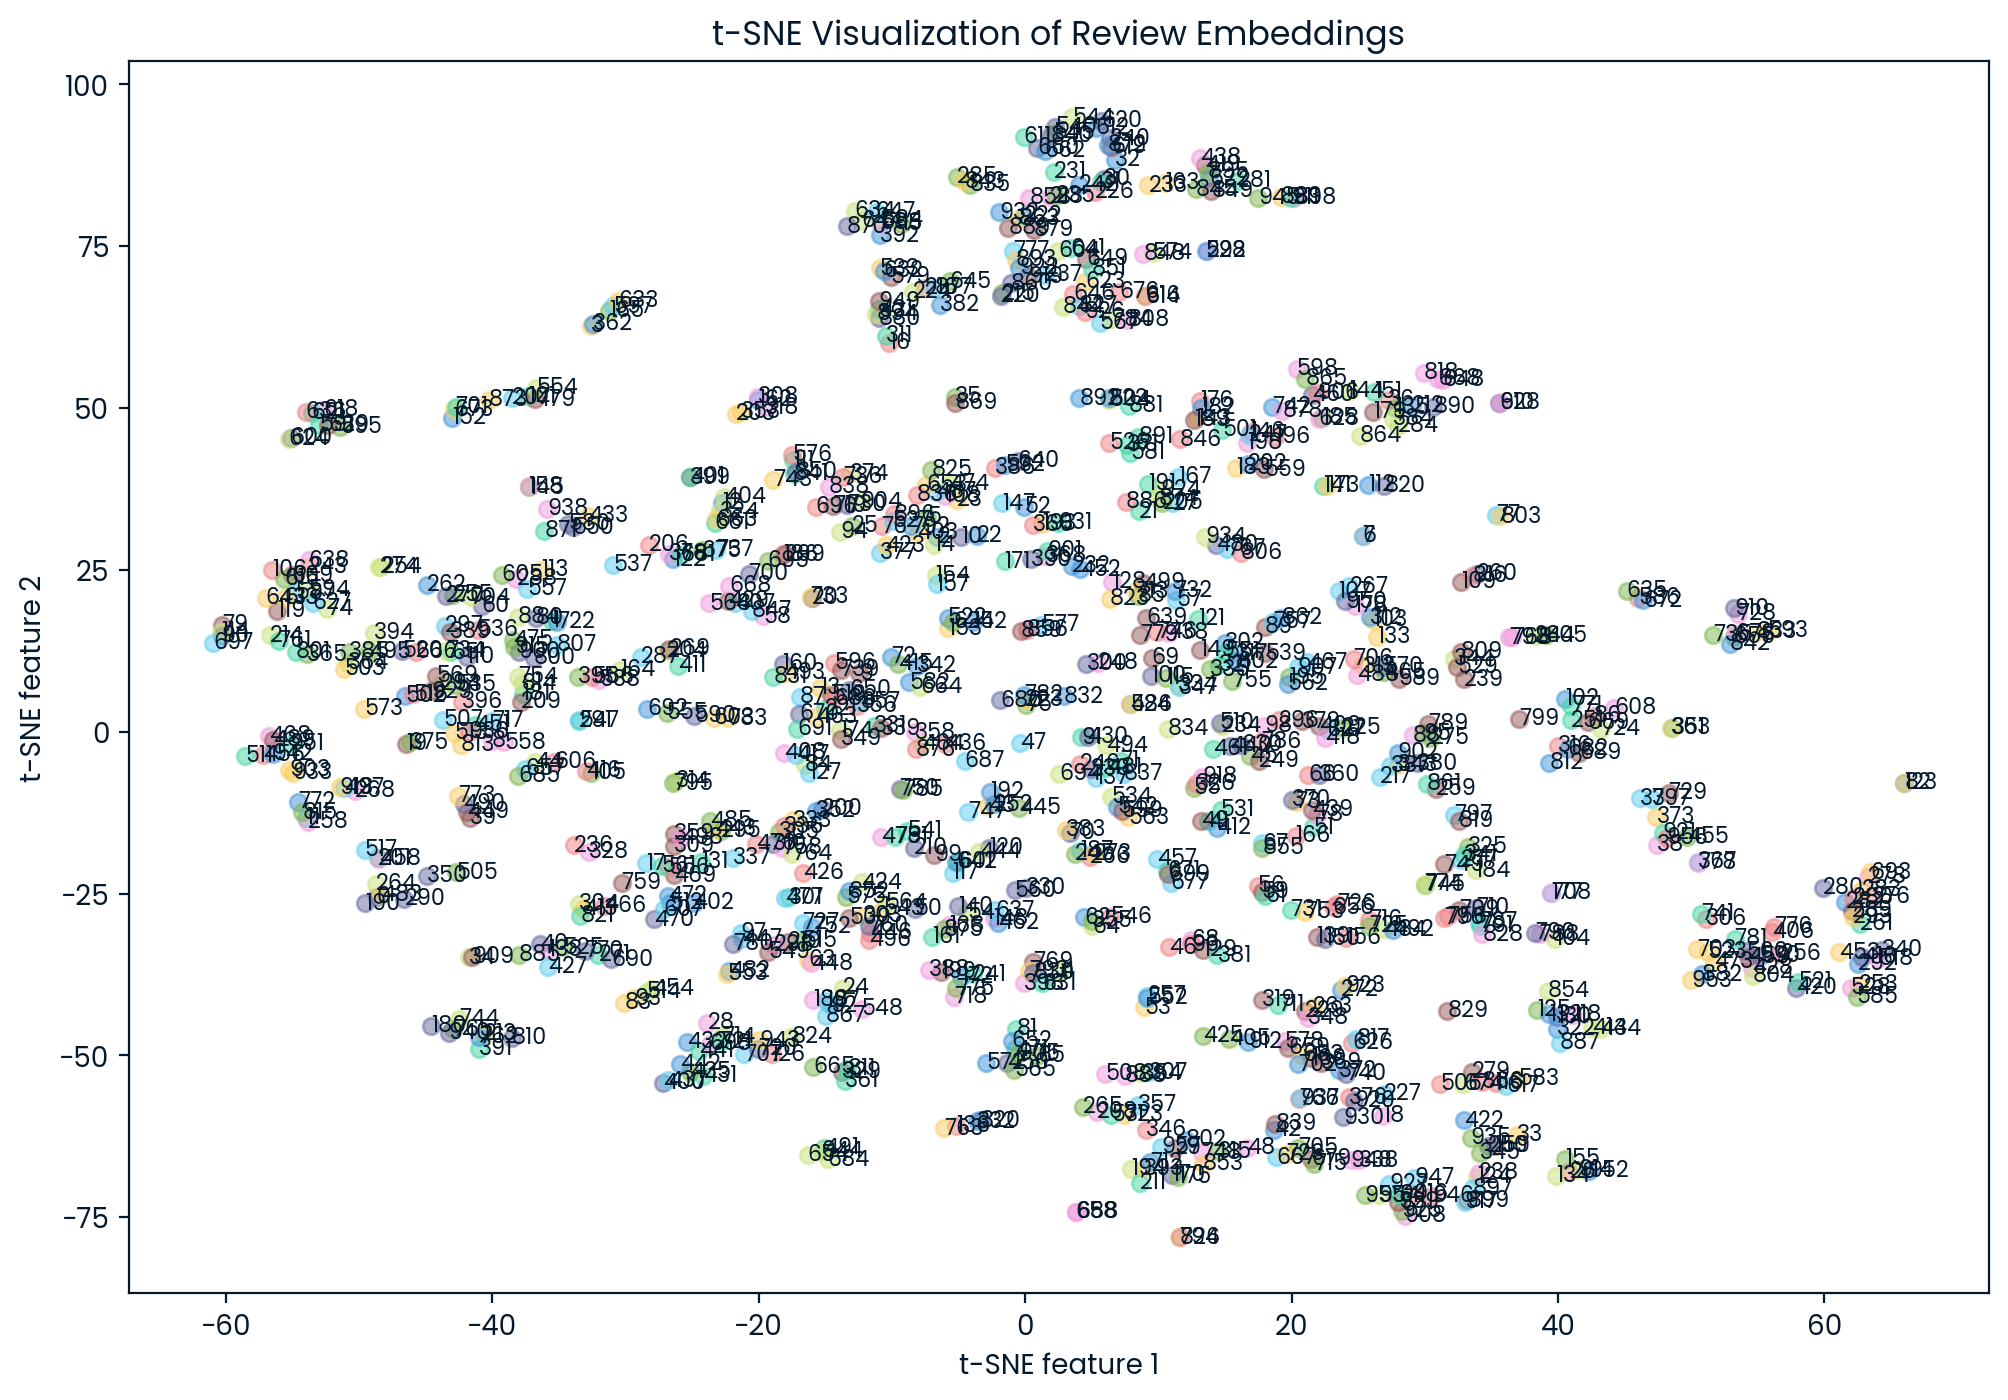

In [34]:
def plot_tsne(tsne_results):
    plt.figure(figsize=(12, 8))
    for i, point in enumerate(tsne_results):
        plt.scatter(point[0], point[1], alpha=0.5)
        plt.text(point[0], point[1], str(i), fontsize=8, verticalalignment='center')
    plt.title("t-SNE Visualization of Review Embeddings")
    plt.xlabel("t-SNE feature 1")
    plt.ylabel("t-SNE feature 2")
    plt.show()

plot_tsne(embeddings_2d)

In [35]:
categories = ["Quality","Fit","Style","Comfort"]
category_responses = client.embeddings.create(
    model = "text-embedding-3-small",
    input = categories
)
response_dict_categories = category_responses.model_dump()
category_embeddings = [category_response["embedding"] for category_response in response_dict_categories["data"]]


In [36]:
def categorize_feedback(text_embedding, category_embeddings):
    from scipy.spatial import distance

    similarities = [
        {"distance": distance.cosine(text_embedding, cat_emb), "index": i}
        for i, cat_emb in enumerate(category_embeddings)
    ]

    closest = min(similarities, key=lambda x: x["distance"])
    return categories[closest["index"]]

feedback_categories = [categorize_feedback(embedding,category_embeddings) for embedding in embeddings]

In [37]:
import os
import chromadb
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction


client = chromadb.PersistentClient()


review_embeddings_db = client.create_collection(
    name="review_embeddings",
    embedding_function=OpenAIEmbeddingFunction(
        model_name="text-embedding-3-small",
        api_key=os.environ["OPENAI_API_KEY"]
    )
)


review_embeddings_db.add(
    documents=review_texts.tolist(),
    ids=[str(i) for i in range(len(review_texts))]
)

def find_similar_reviews(input_text, vector_db, n=3):
   
    collection = client.get_collection(
        name="review_embeddings",
        embedding_function=OpenAIEmbeddingFunction(
            model_name="text-embedding-3-small",
            api_key=os.environ["OPENAI_API_KEY"]
        )
    )
    results = collection.query(
        query_texts=[input_text],
        n_results=n
    )
    return results

example_review = "Absolutely wonderful - silky and sexy and comfortable"
most_similar_reviews = find_similar_reviews(example_review, review_embeddings_db, 3)["documents"][0]
print(most_similar_reviews)


client.delete_collection(name="review_embeddings")

['Absolutely wonderful - silky and sexy and comfortable', 'Very comfortable and versatile. got lots of compliments.', 'This is a very comfortable and sexy sleep dress, the way it drapes. i can see that the type of fabric is not suitable for out and about activities and can catch on snags, etc. very easily. once i relegated it to the nightgown category it became my favorite item to wear and lounge in.']
